In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
#from sessions import selected_009266, selected_008229, selected_009265, selected_57, selected_013829
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from itertools import combinations
from scipy.stats import ttest_rel

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
def pval2text(p_val):
    if p_val > 0.05:
        return 'n.s.'
    elif p_val > 0.01:
        return '*'
    elif p_val > 0.001:
        return '**'
    elif p_val > 0.0001:
        return '***'
    else:
        return '****'

In [5]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list

all_selected[:7], len(all_selected)

(['009266_hippoSIT_2023-04-17_17-04-17',
  '009266_hippoSIT_2023-04-18_10-10-37',
  '009266_hippoSIT_2023-04-18_17-03-10',
  '009266_hippoSIT_2023-04-19_10-33-51',
  '009266_hippoSIT_2023-04-20_08-57-39',
  '009266_hippoSIT_2023-04-21_08-43-00',
  '009266_hippoSIT_2023-04-21_13-12-31'],
 65)

## Multiplexing: sound, locomotion, engagement

In [6]:
animals = list(set([session.split('_')[0] for session in all_selected]))

In [7]:
speed_thresh = 0.04  # m/s
session_stats = {}
corrs = []

for k, session in enumerate(all_selected):
    animal   = session.split('_')[0]
    session_path = os.path.join(source, animal, session)
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
    nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
    bmap_file  = os.path.join(session_path, 'analysis', 'bMAP_segmentation.h5')
    meta_file  = os.path.join(session_path, 'meta.h5')
    desc_file  = os.path.join(session_path, 'descendants.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx = np.array(f['processed']['target_matrix'])
    with h5py.File(nmap_file, 'r') as f:
        fit = np.array(f['response_manifold'])
        unit_mx_ev = np.array(f['unit_mx_proc_ev'])
        unit_mx_su = np.array(f['unit_mx_proc_su'])

    #if os.path.exists(desc_file):
    with h5py.File(desc_file, 'r') as f:
        speed = np.array(f['speed'])
        hd    = np.array(f['hd'])
    # else:
    #     speed = tl[:, 3]
    #     hd    = tl[:, 4]
    speed_ev = speed[sound_events[:, 2].astype(np.int32)]

    with h5py.File(bmap_file, 'r') as f:
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
    idxs_bU_ev = np.array([x for x in range(len(sound_events)) if not x in idxs_tgt_succ_state_ev])
    engaged_ev = np.zeros(len(sound_events))  # just engaged state 0/1, event sampling
    engaged_ev[idxs_tgt_succ_state_ev] = 1

    unit_count = unit_mx_ev.shape[1]
    
    idxs_suc_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_suc_ev = np.array(idxs_suc_ev)

    # auditory state (BGR, SIL etc.) and speed filter
    idxs_sta_ev = np.where(speed_ev < speed_thresh)[0]  # define speed filter here
    idxs_run_ev = np.where(speed_ev > speed_thresh)[0]
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]
    idxs_non_ev = np.where( (sound_events[:, 1] == 0) | (sound_events[:, 1] == 1) )[0]  # non-target

    # for behavioral state
    idxs_non_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_non_ev)
    idxs_non_sta_bE_ev = np.intersect1d(idxs_tgt_succ_state_ev, idxs_non_sta_ev)
    idxs_non_sta_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_sta_ev)
    idxs_sil_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_sil_ev)

    # for speed
    idxs_non_run_ev    = np.intersect1d(idxs_run_ev, idxs_non_ev)
    idxs_non_run_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_run_ev)
    idxs_sil_bU_ev     = np.intersect1d(idxs_bU_ev, idxs_sil_ev)
    
    # multiplexing events: sound, locomotion, engagement

    # ------ NO STIMULUS ------

    # 000: in silence, stationary non-engaged condition
    idxs_000 = np.intersect1d(idxs_sta_ev, idxs_sil_ev)
    idxs_000 = np.intersect1d(idxs_000, idxs_bU_ev)

    # 001: in silence, stationary engaged condition
    idxs_001 = np.intersect1d(idxs_sta_ev, idxs_sil_ev)
    idxs_001 = np.intersect1d(idxs_001, idxs_tgt_succ_state_ev)

    # 010: in silence, running non-engaged condition
    idxs_010 = np.intersect1d(idxs_run_ev, idxs_sil_ev)
    idxs_010 = np.intersect1d(idxs_010, idxs_bU_ev)

    # 011: in silence, running engaged - should not happen!
    idxs_011 = np.intersect1d(idxs_run_ev, idxs_sil_ev)
    idxs_011 = np.intersect1d(idxs_011, idxs_tgt_succ_state_ev)

    # ------ BGR STIMULUS ------

    # 100: in trial, stationary non-engaged condition
    idxs_100 = np.intersect1d(idxs_sta_ev, idxs_bgr_ev)
    idxs_100 = np.intersect1d(idxs_100, idxs_bU_ev)

    # 101: in trial, stationary engaged condition
    idxs_101 = np.intersect1d(idxs_sta_ev, idxs_bgr_ev)
    idxs_101 = np.intersect1d(idxs_101, idxs_tgt_succ_state_ev)

    # 110: in trial, running non-engaged condition
    idxs_110 = np.intersect1d(idxs_run_ev, idxs_bgr_ev)
    idxs_110 = np.intersect1d(idxs_110, idxs_bU_ev)

    # 111: in trial, running engaged - should not happen!
    idxs_111 = np.intersect1d(idxs_run_ev, idxs_bgr_ev)
    idxs_111 = np.intersect1d(idxs_111, idxs_tgt_succ_state_ev)

    corrs.append([
        session,
        np.corrcoef(fit[idxs_sil_ev][:, 0], speed_ev[idxs_sil_ev])[0][1],  # evoked / speed in SIL
        np.corrcoef(fit[idxs_sil_ev][:, 0], engaged_ev[idxs_sil_ev])[0][1],  # evoked / state in SIL
        np.corrcoef(fit[idxs_sil_ev][:, 1], speed_ev[idxs_sil_ev])[0][1],  # sustained / speed in SIL
        np.corrcoef(fit[idxs_sil_ev][:, 1], engaged_ev[idxs_sil_ev])[0][1],  # sustained / state in SIL

        np.corrcoef(fit[idxs_bgr_ev][:, 0], speed_ev[idxs_bgr_ev])[0][1],  # evoked / speed in BGR
        np.corrcoef(fit[idxs_bgr_ev][:, 0], engaged_ev[idxs_bgr_ev])[0][1],  # evoked / state in BGR
        np.corrcoef(fit[idxs_bgr_ev][:, 1], speed_ev[idxs_bgr_ev])[0][1],  # sustained / speed in BGR
        np.corrcoef(fit[idxs_bgr_ev][:, 1], engaged_ev[idxs_bgr_ev])[0][1],  # sustained / state in BGR

        np.corrcoef(fit[idxs_tgt_ev][:, 0], speed_ev[idxs_tgt_ev])[0][1],  # evoked / speed in TGT
        np.corrcoef(fit[idxs_tgt_ev][:, 0], engaged_ev[idxs_tgt_ev])[0][1],  # evoked / state in TGT
        np.corrcoef(fit[idxs_tgt_ev][:, 1], speed_ev[idxs_tgt_ev])[0][1],  # sustained / speed in TGT
        np.corrcoef(fit[idxs_tgt_ev][:, 1], engaged_ev[idxs_tgt_ev])[0][1],  # sustained / state in TGT
        
        np.corrcoef(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1])[0][1],  # evoked / sustained in SIL
        np.corrcoef(fit[idxs_bgr_ev][:, 0], fit[idxs_bgr_ev][:, 1])[0][1],  # evoked / sustained in SIL
        np.corrcoef(fit[idxs_tgt_ev][:, 0], fit[idxs_tgt_ev][:, 1])[0][1],  # evoked / sustained in SIL
    ])
    
    # save stats - median evoked, median sutained, pulse count
    session_stats[session] = {
        '000': [np.median(fit[idxs_000][:, 0]), np.median(fit[idxs_000][:, 1]), len(idxs_000)],
        '001': [np.median(fit[idxs_001][:, 0]), np.median(fit[idxs_001][:, 1]), len(idxs_001)],
        '010': [np.median(fit[idxs_010][:, 0]), np.median(fit[idxs_010][:, 1]), len(idxs_010)],
        '100': [np.median(fit[idxs_100][:, 0]), np.median(fit[idxs_100][:, 1]), len(idxs_100)],
        '101': [np.median(fit[idxs_101][:, 0]), np.median(fit[idxs_101][:, 1]), len(idxs_101)],
        '110': [np.median(fit[idxs_110][:, 0]), np.median(fit[idxs_110][:, 1]), len(idxs_110)],
    }
    
    print(f"Session {session} completed ({k} from {len(all_selected)})\r", end='')

## Medians

In [8]:
animals = ['009266', '013829', '009265', '57']

In [9]:
# construct a dataframe for ANOVAs
df = []
for session, s_stats in session_stats.items():
    animal = session.split('_')[0]
    
    for condition, data in s_stats.items():
        df.append([animal, condition, data[0], data[1]])
        
df_stats = pd.DataFrame(df, columns=['animal', 'condition', 'evoked', 'sustained'])
df_stats.head(3)

,animal,condition,evoked,sustained
0,009266,000,0.184577,-0.065657
1,009266,001,0.112426,-0.049891
2,009266,010,0.148546,0.019565


In [10]:
# ANOVA for No stimulus
df_SIL = df_stats[(df_stats['condition'] == '000') | (df_stats['condition'] == '001') | (df_stats['condition'] == '010')]
df_BGR = df_stats[(df_stats['condition'] == '100') | (df_stats['condition'] == '101') | (df_stats['condition'] == '110')]

anovas = [
    AnovaRM(df_SIL, depvar="evoked", subject="animal", within=["condition"], aggregate_func='mean').fit(),
    AnovaRM(df_SIL, depvar="sustained", subject="animal", within=["condition"], aggregate_func='mean').fit(),
    AnovaRM(df_BGR, depvar="evoked", subject="animal", within=["condition"], aggregate_func='mean').fit(),
    AnovaRM(df_BGR, depvar="sustained", subject="animal", within=["condition"], aggregate_func='mean').fit(),
]

# p-values
for anova in anovas:
    print(anova.anova_table["Pr > F"][0])

0.9009541855973021
0.0011061089509049127
0.3321918242193362
0.0003718718799361386


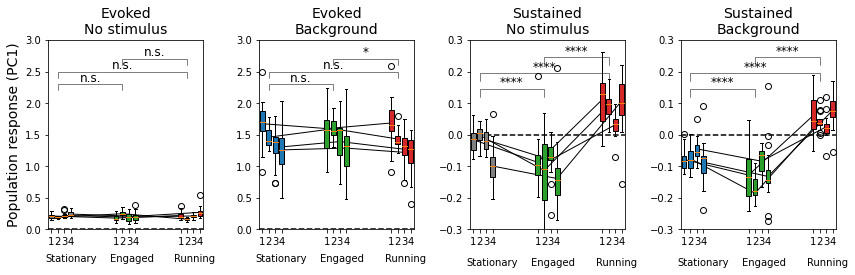

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))

bg_dist = 10  # distance between groups
combs = [
    ('evoked', ['000', '001', '010']),
    ('evoked', ['100', '101', '110']),
    ('sustained', ['000', '001', '010']),
    ('sustained', ['100', '101', '110']),
]
ylims = [
    (0, 3),
    (0, 3),
    (-0.3, 0.3),
    (-0.3, 0.3),
]
titles = ['Evoked\nNo stimulus', 'Evoked\nBackground', 'Sustained\nNo stimulus', 'Sustained\nBackground']
colors = [
    ['grey', 'tab:green', 'tab:red'],
    ['tab:blue', 'tab:green', 'tab:red'],
    ['grey', 'tab:green', 'tab:red'],
    ['tab:blue', 'tab:green', 'tab:red']
]
conds = ['Stationary', 'Engaged', 'Running']
y_txt_pos = [-0.5, -0.5, -0.415, -0.415]
y_sts_pos = [
    ( 2.2, 0.1),
    (2.2, 0.1),
    (0.12, 0.025),
    (0.12, 0.025)
]

for j, ax in enumerate(axes):
    means = []
    conditions = combs[j][1]
    for i, s_type in enumerate(conditions):
        data = []
        for animal in animals:
            #a_data = [v[s_type][combs[j][0]] for k, v in session_stats.items() if k.split('_')[0] == animal]
            a_data = df_stats[(df_stats['animal'] == animal) & (df_stats['condition'] == s_type)][combs[j][0]].values
            data.append(a_data)

        bplot = ax.boxplot(data, positions=np.arange(i*bg_dist + 1, i*bg_dist + len(data)+1), widths=0.75, patch_artist=True)
        for patch, color in zip(bplot['boxes'], len(data) * [colors[j][i]]):
            patch.set_facecolor(color)
            
        means.append(np.array([np.array(points).mean() for points in data]))    
            
    # Perform paired t-tests
    comb_pairs = [x for x in combinations(conditions, 2)]
    xval_pairs = [x for x in combinations(np.arange(3)*bg_dist + 2, 2)]
    for i in range(len(comb_pairs)):
        group1 = df_stats[df_stats["condition"] == comb_pairs[i][0]][combs[j][0]]
        group2 = df_stats[df_stats["condition"] == comb_pairs[i][1]][combs[j][0]]
        t_stat, p_value = ttest_rel(group1, group2)
        
        x1, x2 = xval_pairs[i][0], xval_pairs[i][1]
        y, h = y_sts_pos[j][0] + i*2*y_sts_pos[j][1], y_sts_pos[j][1]
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, color='black')
        ax.text((x1+x2)*.5, y+h, pval2text(p_value), ha='center', va='bottom', color='black', fontsize=12)

    for m, animal_mean in enumerate(np.array(means).T):
        ax.plot(np.arange(3)*bg_dist + (m+1), animal_mean, color='black', lw=1)

    ax.axhline(0, color='black', ls='--')
    ax.set_ylim(ylims[j][0], ylims[j][1])
    ax.set_title(titles[j], fontsize=14)
    ax.set_xticklabels([1, 2, 3, 4] * 3, rotation=0)
    
    for i in np.arange(3):
        ax.text(i*bg_dist, y_txt_pos[j], conds[i])

axes[0].set_ylabel('Population response (PC1)', fontsize=14)

fig.tight_layout()
#fig.savefig(os.path.join(rep_path, 'EV_SU_means_cross_session.png'), dpi=300)

In [12]:
descs = ['No stimulus, Evoked', 'No stimulus, Sustained', 'Backgound, Evoked', 'Backgound, Sustained']
for i, anova in enumerate(anovas):
    print(f"{descs[i]}: {anova.anova_table['Pr > F'][0]}")

No stimulus, Evoked: 0.9009541855973021
No stimulus, Sustained: 0.0011061089509049127
Backgound, Evoked: 0.3321918242193362
Backgound, Sustained: 0.0003718718799361386


In [13]:
# TODO: study outliers!!

## Corrs

In [15]:
df_corr = pd.DataFrame(corrs, columns=['session', 'sil_ev_speed', 'sil_ev_state', 'sil_su_speed', 'sil_su_state', \
                                       'bgr_ev_speed', 'bgr_ev_state', 'bgr_su_speed', 'bgr_su_state', \
                                       'tgt_ev_speed', 'tgt_ev_state', 'tgt_su_speed', 'tgt_su_state', \
                                       'sil_ev_su', 'bgr_ev_su', 'tgt_ev_su'])

5.472418936643216e-10
3.9194799832314433e-10
7.312395513482799e-10


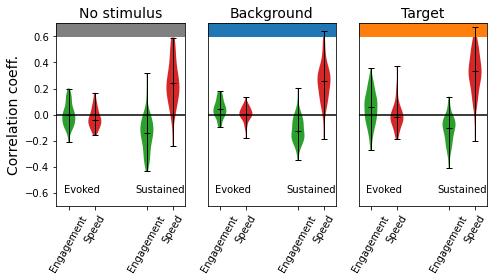

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(7, 4))

titles = ['No stimulus', 'Background', 'Target']
x_pos = [1, 2, 4, 5]
colors = ['grey', 'tab:blue', 'tab:orange']

for i, s_type in enumerate(['sil', 'bgr', 'tgt']):
    ax = axes[i]

    data = [
        df_corr[f'{s_type}_ev_state'].values,
        df_corr[f'{s_type}_ev_speed'].values,
        df_corr[f'{s_type}_su_state'].values,
        df_corr[f'{s_type}_su_speed'].values
    ]
    stat, p = stats.wilcoxon(data[2])
    print(p)

    parts = ax.violinplot(data, positions=x_pos, showmeans=False, showmedians=True)
    for j, pc in enumerate(parts['bodies']):
        pc.set_facecolor('tab:green' if j%2 == 0 else 'tab:red')
        #pc.set_edgecolor(colors[i])
        pc.set_alpha(1)
    # Make all the violin statistics marks black:
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = parts[partname]
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
        
    ax.axhline(0, color='black')
    ax.set_ylim(-0.7, 0.7)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['Engagement', 'Speed', 'Engagement', 'Speed'], rotation=60)
    ax.set_title(titles[i], fontsize=14)
    ax.text((x_pos[0]+x_pos[1])*0.5, -0.6, 'Evoked', ha='center')
    ax.text((x_pos[2]+x_pos[3])*0.5, -0.6, 'Sustained', ha='center')
    #ax.set_facecolor(colors[i])
    ax.axhspan(0.6, 0.7, color=colors[i])
    
axes[0].set_ylabel('Correlation coeff.', fontsize=14)
axes[1].set_yticks([])
axes[2].set_yticks([])
fig.tight_layout()
#fig.savefig(os.path.join(rep_path, 'EV_SU_corrs_cross_session.png'), dpi=300)

## Corrs between metrics EV / SU

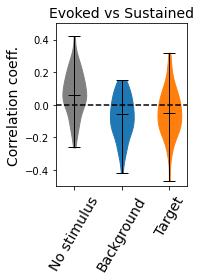

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 4))

labels = ['No stimulus', 'Background', 'Target']
x_pos  = [1, 2, 3]
colors = ['grey', 'tab:blue', 'tab:orange']

data = [
    df_corr['sil_ev_su'].values,
    df_corr['bgr_ev_su'].values,
    df_corr['tgt_ev_su'].values,
]

parts = ax.violinplot(data, positions=x_pos, showmeans=False, showmedians=True)
for j, pc in enumerate(parts['bodies']):
    pc.set_facecolor(colors[j])
    pc.set_edgecolor(colors[j])
    pc.set_alpha(1)
    
# Make all the violin statistics marks black:
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = parts[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
        
ax.axhline(0, color='black', ls='--')
ax.set_ylim(-0.5, 0.5)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, rotation=60, fontsize=14)
ax.set_title("Evoked vs Sustained", fontsize=14)
    
ax.set_ylabel('Correlation coeff.', fontsize=14)
fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'EV_SU_corrs_cross_session_ALL_STATES.png'), dpi=300)

In [ ]:
import matplotlib

for c in plt.cm.tab10.colors: 
    print(matplotlib.colors.to_hex(c))

In [ ]:
matplotlib.colors.cnames["grey"]